# Market generator 
###### Source: https://github.com/imanolperez/market_simulator

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator
from utils import tosig

In [3]:
# Signature order
order = 4

## Load monthly paths

In [4]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=order)

Computing log-signatures: 100%|█████████████| 992/992 [00:00<00:00, 6286.04it/s]


## Plot paths

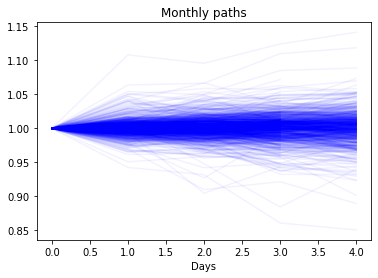

In [5]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [6]:
MG.train(n_epochs=10000)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


2022-07-22 22:25:51.714171: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Training: 100%|██████████████████████████| 10000/10000 [00:39<00:00, 252.62it/s]


## Generate

In [7]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|█████████████████████████████████████████| 992/992 [00:33<00:00, 29.63it/s]


In [61]:
generated_sigs.shape

(991, 31)

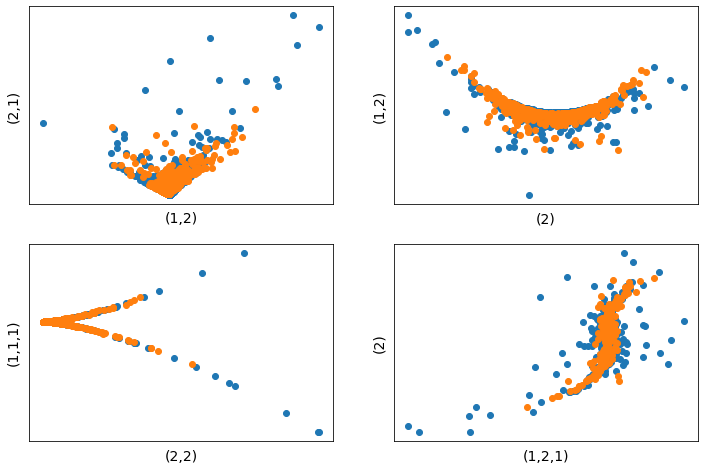

In [8]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [9]:
import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██| 991/991 [00:01<00:00, 609.02it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [10]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [11]:
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

Loss: 0.27947599397444145: 100%|██████████████| 100/100 [00:14<00:00,  6.92it/s]


In [63]:
logsig

array([-1.6323423e+01, -1.7051380e+01, -1.9320137e+02, -2.9173772e+03,
        5.5422173e+03,  1.5007776e+04,  7.2822500e+04, -3.7940438e+04],
      dtype=float32)

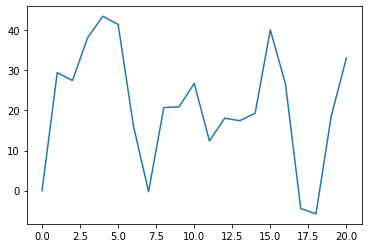

Target log-signature: [37.891754150390625, 38.2727165222168, -548.138671875, 3466.101318359375, -1531.031494140625, -42877.796875, -27388.4375, -67819.0]
Recovered log-signature: [33.11, 33.11, -2513.7536499999997, -1391.430574083323, -2609.710222916671, -65391.410900590185, 15829.57852320655, -44686.637151454896]


In [12]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [14]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path) 

Loss: 0.9442989756324387: 100%|███████████████| 100/100 [00:15<00:00,  6.53it/s]


Loss: 0.6326770569627744: 100%|███████████████| 100/100 [00:19<00:00,  5.23it/s]


Loss: 0.2027130537821383: 100%|███████████████| 100/100 [00:12<00:00,  7.76it/s]


Loss: 0.11961224849793815: 100%|██████████████| 100/100 [00:13<00:00,  7.21it/s]


Loss: 0.1893957889841213: 100%|███████████████| 100/100 [00:13<00:00,  7.32it/s]


Loss: 0.8822104257348151: 100%|███████████████| 100/100 [00:13<00:00,  7.23it/s]


Loss: 0.17509729064662322: 100%|██████████████| 100/100 [00:13<00:00,  7.34it/s]


Loss: 0.33783492861311004: 100%|████████████| 100/100 [1:34:19<00:00, 56.59s/it]


Loss: 1.0992053284223071: 100%|███████████████| 100/100 [00:16<00:00,  6.09it/s]


Loss: 0.19481601724440054: 100%|██████████████| 100/100 [00:13<00:00,  7.42it/s]


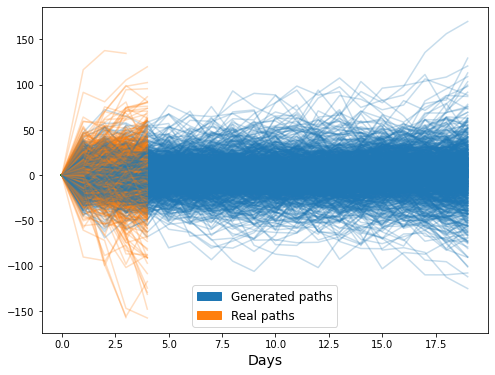

In [221]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(path, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

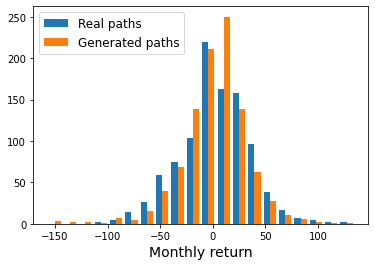

In [68]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14) 
plt.legend(fontsize=12)
plt.show()

In [217]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

Loss: 0.20803868846913454: 100%|██████████████| 100/100 [00:14<00:00,  6.87it/s]


Loss: 0.05923151104739682: 100%|██████████████| 100/100 [00:13<00:00,  7.55it/s]


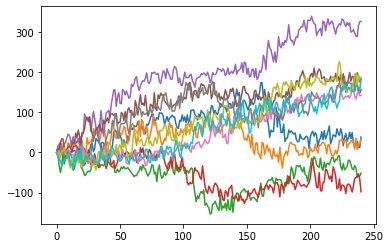

In [218]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

# Evaluation Metrics: Comparison with GANs

In [184]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import pandas as pd


In [210]:
real = np.array(returns1)
generated = np.array(returns2)

In [97]:
#R-squared 

from sklearn.linear_model import LinearRegression
X = real.reshape(-1,1)
Y = generated.reshape(-1, 1)[: -1]
model = LinearRegression()
model.fit(X, Y)
r2_trtr = model.score(X, Y)
r2_trtr

0.005581086531108337

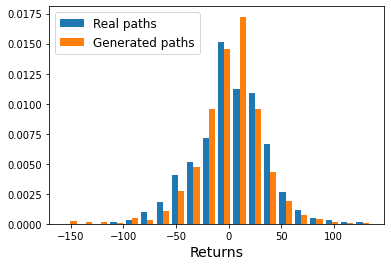

0.01751965830330658

In [201]:
#Metric on denisty

_ = plt.hist([returns1, returns2], bins=20, density = True, label=["Real paths", "Generated paths"])
plt.xlabel("Returns", fontsize=14) 
plt.legend(fontsize=12)
plt.show()

real_hist = np.histogram(real, bins = 20, density = True)
gen_hist = np.histogram(generated, bins = 20, density = True)

df = np.abs(np.sum(real_hist[0] - gen_hist[0]))
df

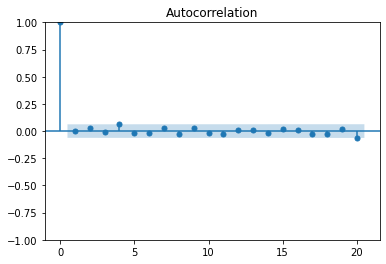

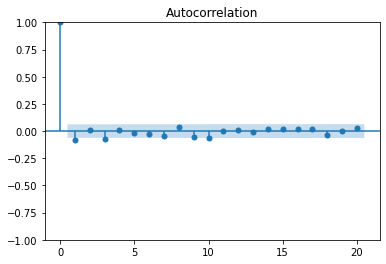

0.08263171751477634


In [202]:
#ACF 
#import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
acf_real = acf(real, nlags = 1)
acf_gen = acf(generated, nlags = 1)
acf_loss = np.abs((acf_gen[1] - acf_real[1]))


#plot autocorrelation function
fig = tsaplots.plot_acf(real, lags=20)
fig2 = tsaplots.plot_acf(generated, lags=20)
plt.show()
print(acf_loss)

<AxesSubplot:>

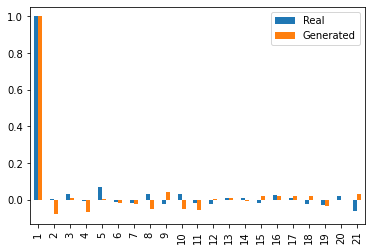

In [203]:
acf_real = acf(real, nlags = 20)
acf_gen = acf(generated, nlags = 20)
test_df = pd.DataFrame([acf_real, acf_gen]).T
test_df.columns = ['Real', 'Generated']
test_df.index += 1
test_df.plot(kind='bar')

# Generation of Data with VAR

[array([[ 0.35545152],
        [-0.47230723],
        [ 0.8528153 ],
        [ 0.66879413],
        [-0.22867965],
        [-0.37818699],
        [ 0.3949606 ],
        [-0.3025768 ],
        [ 0.18222352],
        [ 0.26686964],
        [ 0.47261115],
        [ 0.43267654],
        [-0.43169303],
        [-0.8510823 ],
        [ 0.62357968],
        [-0.002542  ],
        [-0.31713601],
        [ 0.3703613 ],
        [-1.07094923],
        [-0.70712236],
        [-0.7252586 ],
        [-0.29988269],
        [-0.83304622],
        [ 0.0663168 ],
        [ 0.06847985],
        [-0.66727246],
        [-1.16131401],
        [-0.76999992],
        [ 0.08312243],
        [-0.26560286],
        [-1.52197039],
        [-0.85944313],
        [-0.04781322],
        [-0.40624828],
        [ 0.51876964],
        [ 0.09845586],
        [-0.48650702],
        [-1.24292084],
        [-0.43757316],
        [-1.16906813],
        [-1.53185237],
        [-0.07904317],
        [-0.17522366],
        [-1

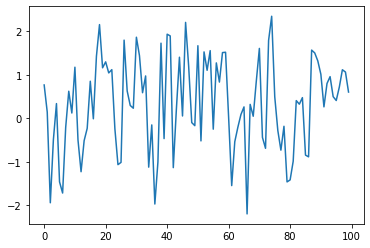

In [222]:
def multi_AR(window_size, dim=1, phi=0.8, sigma=0.5, burn_in=200):
    window_size = window_size + burn_in
    xt = np.zeros((window_size, dim))
    one = np.ones(dim)
    ide = np.identity(dim)
    MU = np.zeros(dim)
    COV = sigma * one + (1 - sigma) * ide
    W = np.random.multivariate_normal(MU, COV, window_size)
    for i in range(dim):
        xt[0, i] = 0
    for t in range(window_size - 1):
        xt[t + 1] = phi * xt[t] + W[t]
    return xt[burn_in:]

trialpath = multi_AR(window_size= 100, dim=1, phi=0.3, sigma=0.5, burn_in=200)
plt.plot(trialpath)
trialpath.shape

path = []
for i in range(1000):
        tmp = multi_AR(window_size= 100, dim=1, phi=0.8, sigma=0.5, burn_in=200)
        normal_trial = (tmp-tmp.mean())/tmp.std()
        #normal_trial = normal_trial.cumsum()
        path.append(normal_trial)
path

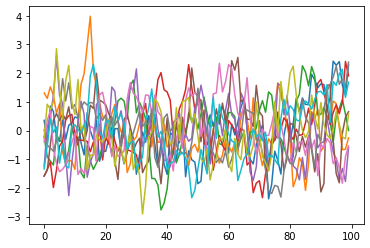

In [223]:
for i in range(10):
    plt.plot(path[i])
plt.show()

In [225]:
# Compute log-signature

order = 4
leadlag_path = leadlag(path[:2])

logsignatures = []

for i in range(len(leadlag_path)):
    logsig = tosig.stream2logsig(leadlag_path[i,:], order)
    logsignatures.append(logsig)

logsignatures = np.array(logsignatures)
logsignatures

array([[ 1.94221171,  1.94221171,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.94221171, -1.56695305,  3.78014352, -3.309429  , -2.97911846,
        -0.37977634,  3.61742218,  4.60681201],
       [-1.56695305, -1.56695305,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])